## Метод треугольников на базе метода двойственных усреднений

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import sys

import scipy.stats as sts

from numpy.linalg import norm

#sys.path.insert(0, "../Zeudel, Gauss methods/")
from uigm import FastDualAveraging, Gradient

plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
plt.rcParams['figure.figsize'] = (16, 10)

### Исследуем метод на сходимость и характер приближения к решению
Будем рассматривать 2-мерное пространство для удобства визуализации, h пока считаем постоянным.

Для наглядности сравним метод с стандартным методом град. спуска

In [3]:
A = np.array([[1, 2], [2, 3]])
b = np.array([1, 2])
x_expl = np.array([1, 0])
x0_rn = np.array([0.1, 0.2])
x0_smp = np.array([0.1, 0.2])
eps = 0.00005

# ||Ax - b||^2
def func1(x):
    return np.linalg.norm(np.dot(A, x) - b, ord = 2)**2


def gradFunc1(x, func1, eps = 0) :
    return 2*A.transpose() @ (A @ x - b)

#### Построим траекторию сходимости методов для ф-ции ||Ax - b||^2 для Rn
Для симплекса метод не сходится

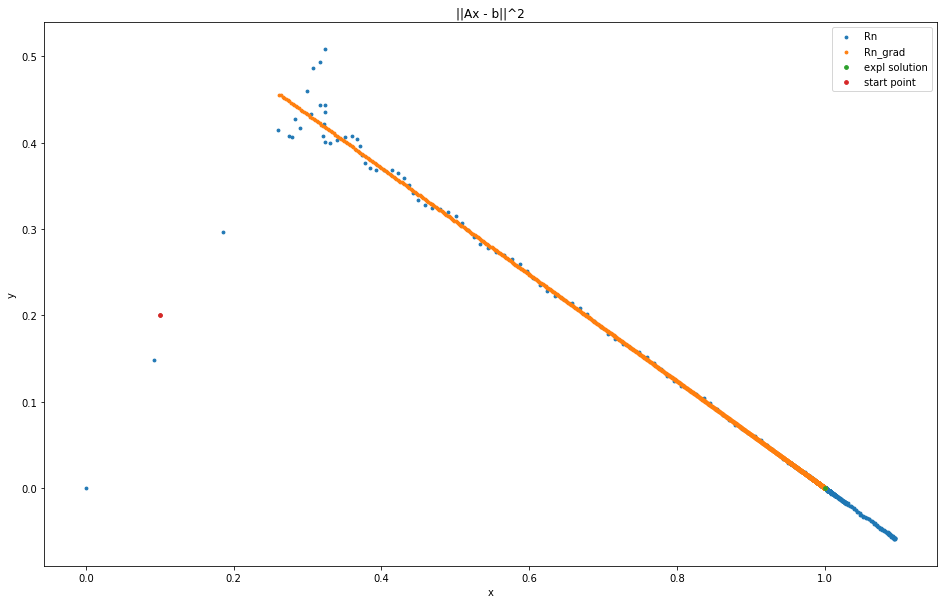

In [4]:
L = 36

xk_rn   = FastDualAveraging(func1, x0_rn,  eps, set_type = "rn", grad = gradFunc1, step = lambda k: (k+1)/(2*L), alpha = lambda k: 2/(k+1))
xk_grad = Gradient(func1, x0_rn, eps, L, set_type = "rn", grad = gradFunc1)

plt.scatter([xk_rn[i][0] for i in range(0, len(xk_rn))], [xk_rn[i][1] for i in range(0, len(xk_rn))], label = "Rn", s=8)
plt.scatter([xk_grad[i][0] for i in range(0, len(xk_grad))], [xk_grad[i][1] for i in range(0, len(xk_grad))], label = "Rn_grad", s=8)

plt.scatter(x_expl[0], x_expl[1], label = "expl solution", s = 14)
plt.scatter(x0_rn[0],  x0_rn[1],  label = "start point",   s = 14)

plt.xlabel("x")
plt.ylabel("y")
plt.title("||Ax - b||^2")
plt.legend()

#### Построим график :
$$lnDiff(k) = \ln\left(\frac{f(x_k) - f(x_*)}{f(x_0) - f(x_*)}\right)$$

In [5]:
def ln_diff(x):
    return np.log((func1(x) - func1(x_expl))/(func1(x0_rn) - func1(x_expl)))

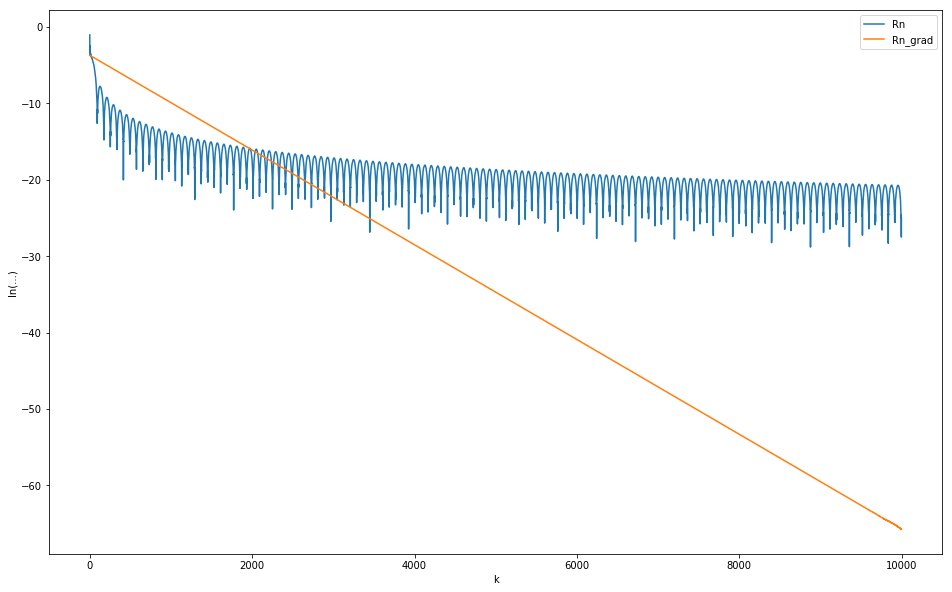

In [6]:
plt.plot([ln_diff(xk_rn[i]) for i in range(3, len(xk_rn))], label = "Rn")
plt.plot([ln_diff(xk_grad[i]) for i in range(3, len(xk_grad))], label = "Rn_grad")
plt.xlabel("k")
plt.ylabel("ln(...)")
plt.legend()

In [7]:
xk_rn[len(xk_rn) - 1]

array([ 1.00001118e+00, -5.82048279e-06])

In [8]:
xk_grad[len(xk_grad) - 1]

array([1.00000000e+00, 1.54662718e-14])

- Как выбирать Y0, Z0, h, L, alpha для наперед заданной функции?
- Как контролировать точность нахождения решения?

## Тест на различных матрицах NxN

In [41]:
N = 50 # размерность пространства

# генерируем случайные A и b
uniform_rv = sts.uniform(-100, 200) # Равномерное распределение от -10 до 10
A = uniform_rv.rvs(size = (N, N))
b = uniform_rv.rvs(size = N)
x0_rn = np.zeros(N)

x_expl = np.linalg.inv(A) @ b

L = max(abs(np.linalg.eig(2 * A.transpose() @ A)[0]))

In [42]:
xk_rn   = FastDualAveraging(func1, x0_rn,  eps, set_type = "rn", grad = gradFunc1, step = lambda k: (k+1)/(2*L), alpha = lambda k: 2/(k+1))
xk_grad = Gradient(func1, x0_rn, eps, L, set_type = "rn", grad = gradFunc1)

#plt.scatter([xk_rn[i][0] for i in range(0, len(xk_rn))], [xk_rn[i][1] for i in range(0, len(xk_rn))], label = "Rn", s=8)
#plt.scatter([xk_grad[i][0] for i in range(0, len(xk_grad))], [xk_grad[i][1] for i in range(0, len(xk_grad))], label = "Rn_grad", s=8)
#plt.xlabel("x")
#plt.ylabel("y")
#plt.title("||Ax - b||^2")
#plt.legend()

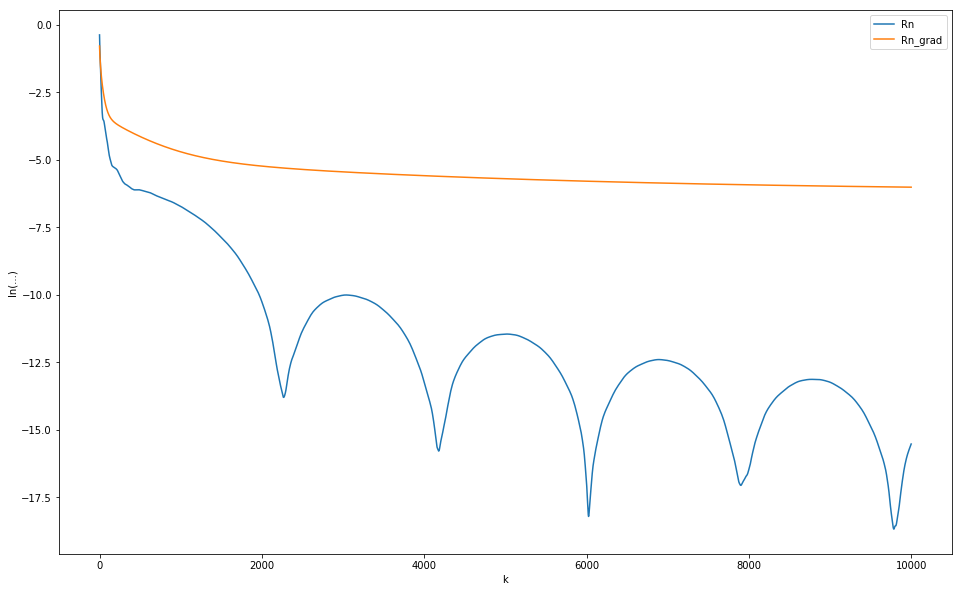

In [43]:
plt.plot([ln_diff(xk_rn[i]) for i in range(3, len(xk_rn))], label = "Rn")
plt.plot([ln_diff(xk_grad[i]) for i in range(3, len(xk_grad))], label = "Rn_grad")
plt.xlabel("k")
plt.ylabel("ln(...)")
plt.legend()

In [44]:
print("Метод треугольников: ", "f(x) = ", func1(xk_rn[len(xk_rn) - 1]))
print("Градиентный метод: ", "f(x) = ", func1(xk_grad[len(xk_grad) - 1]))

Метод треугольников:  f(x) =  0.029389189796863176
Градиентный метод:  f(x) =  400.2759213494372


In [45]:
func1(x_expl)

4.9184631781639683e-23

In [46]:
norm(xk_rn[len(xk_rn) - 1] - x_expl)

0.09102448959946083